## Day Type Identification of Algerian Electricity Load

**Introduction:**

This Jupyter notebook explores the identification of different day types based on electricity load patterns in an Algerian city. We will analyze a dataset containing hourly recordings of Maximum Power Demand (PMA) and Temperature for two years, from January 1st, 2016, to December 31st, 2017.

**Data Source:**

The dataset used in this analysis is stored in a file named `pma.xlsx`. It contains three columns:

* `time`: Date and time (hourly)
* `pma`: Maximum Power Demand (MW)
* `tmp`: Temperature (°C)

**Software and Tools:**

This project will utilize Python libraries such as:

* `pandas` for data manipulation and analysis
* `numpy` for scientific computing
* `matplotlib` and `seaborn` for data visualization
* `scikit-learn` for machine learning and clustering algorithms

**Let's begin by importing the necessary libraries and reading the data into a Pandas dataframe.**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering

In [2]:
data_path = "pma.xlsx"

df = pd.read_excel(data_path, skiprows=1)

df.columns = ["time", "pma", "tmp"]

df['time'] = pd.to_datetime(df['time'])

df.head()

,time,pma,tmp
0,2016-01-01 01:00:00,982.529002,6.405644
1,2016-01-01 02:00:00,983.240592,5.932445
2,2016-01-01 03:00:00,1002.780354,5.503807
3,2016-01-01 04:00:00,1011.657004,5.112056
4,2016-01-01 05:00:00,999.137230,4.751342


## Exploratory Data Analysis

#### shape of the data

In [3]:
print(f'number of rows: {df.shape[0]}')
print(f'number of columns: {df.shape[1]}')

number of rows: 17543
number of columns: 3


#### description

In [4]:
df.describe()

,time,pma,tmp
count,17543,17543.000000,17543.000000
mean,2016-12-31 12:00:00,1270.604817,17.971414
min,2016-01-01 01:00:00,558.397028,-1.377706
25%,2016-07-01 18:30:00,1091.574864,10.856301
50%,2016-12-31 12:00:00,1252.618854,17.281236
75%,2017-07-02 05:30:00,1429.612106,24.250000
max,2017-12-31 23:00:00,2174.951321,42.500000
std,NaN,256.452804,8.773186


#### missing data

In [5]:
total_missing_values = df.isna().sum().sum()
print(f'total of missing values: {total_missing_values}')

total of missing values: 0


#### duplicates

In [6]:
total_duplicates = df.duplicated().sum()
print(f'total of missing values: {total_duplicates}')

total of missing values: 0


In [7]:
# spread tme into several columns for better groupping
df['hour'] = df.time.dt.hour
df['day'] = df.time.dt.day
df['month'] = df.time.dt.month
df['year'] = df.time.dt.year
df

,time,pma,tmp,hour,day,month,year
0,2016-01-01 01:00:00,982.529002,6.405644,1,1,1,2016
1,2016-01-01 02:00:00,983.240592,5.932445,2,1,1,2016
2,2016-01-01 03:00:00,1002.780354,5.503807,3,1,1,2016
3,2016-01-01 04:00:00,1011.657004,5.112056,4,1,1,2016
4,2016-01-01 05:00:00,999.137230,4.751342,5,1,1,2016
...,...,...,...,...,...,...,...
17538,2017-12-31 19:00:00,1709.119118,13.065041,19,31,12,2017
17539,2017-12-31 20:00:00,1722.716647,11.938791,20,31,12,2017
17540,2017-12-31 21:00:00,1638.983132,11.057673,21,31,12,2017
17541,2017-12-31 22:00:00,1469.853568,10.333822,22,31,12,2017


### Trends

#### PMA over all time

Here, we will try to see the development of the maximum power demand over time in 2016 and 2017 by months

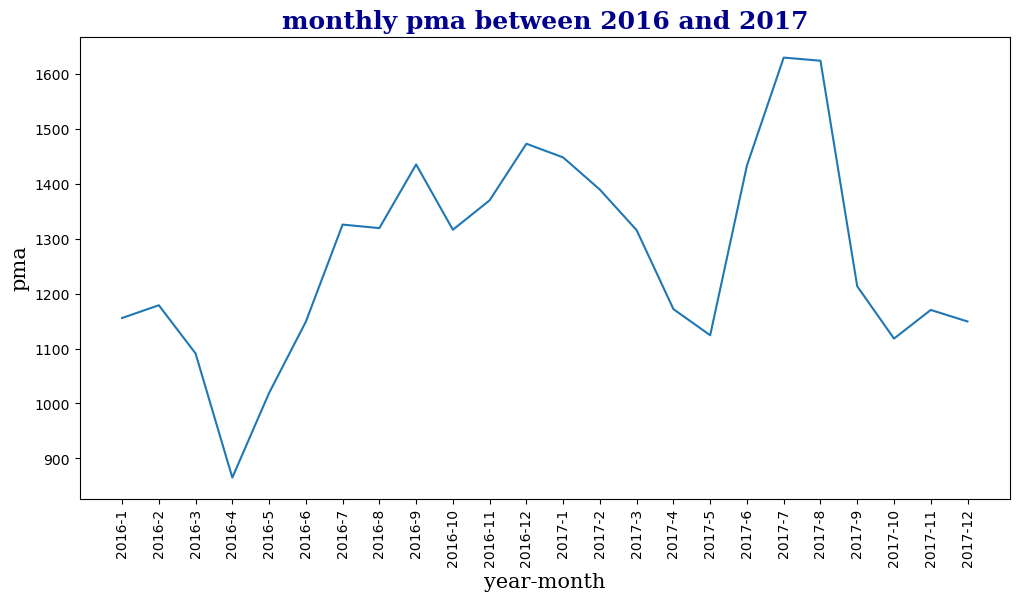

In [60]:
# group
year_month_grouped_pma = df.groupby(['year', 'month']).pma.agg(years_monthly_pma='mean')

title_style = {'family':'serif','color':'darkblue','size':18, 'weight':'bold'}
labels_style = {'family':'serif','color':'black','size':15}
def line_plot(data, x, y, title='', xlabel='', ylabel='', rotate_x=0):
    plt.figure(figsize=[12, 6])
    plt.title(title, fontdict=title_style)
    plt.ylabel(ylabel, fontdict=labels_style)
    plt.xlabel(xlabel, fontdict=labels_style)
    plt.xticks(rotation=rotate_x)
    sns.lineplot(data=data, x=x, y=y)
    plt.show()

# adding a column for the combination year-month
year_month_grouped_pma['year_month'] = year_month_grouped_pma.index.map(lambda x: f'{x[0]}' + '-' + f'{x[1]}')
# year_month_grouped_pma

# plotting the data
line_plot(year_month_grouped_pma, 'year_month', 'years_monthly_pma', 'monthly pma between 2016 and 2017', 'year-month', 'pma', 90)

As we notice, for now, maximum power demand increases mostly during summer from May till October.  
To see this better, let us take the average pma between the two years for ech month:

#### PMA over months

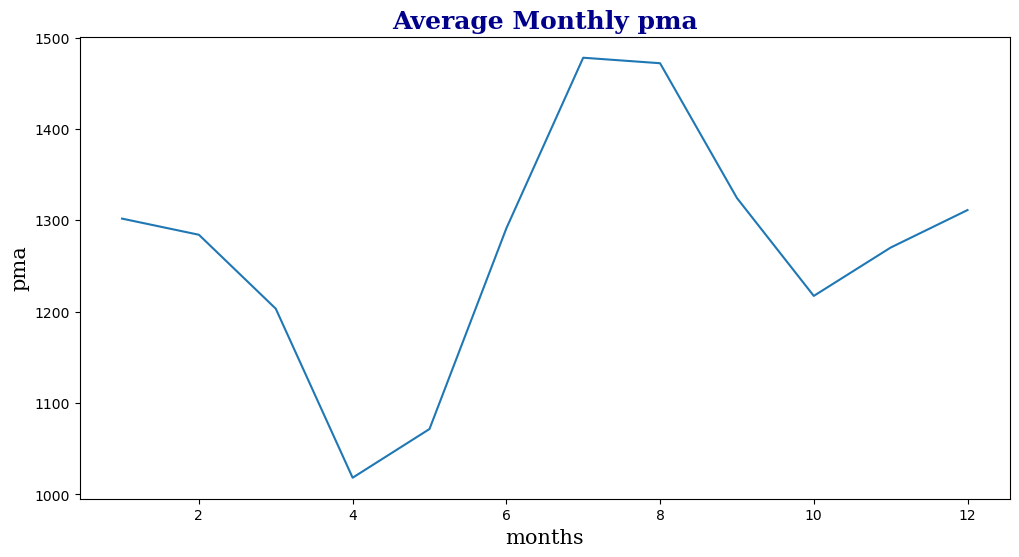

In [41]:
year_month_grouped_pma
monthly_grouped_pma = year_month_grouped_pma.groupby('month').years_monthly_pma.agg(average_monthly_pma='mean')
# monthly_grouped_pma
line_plot(monthly_grouped_pma, 'month', 'average_monthly_pma', 'Average Monthly pma', 'months', 'pma')

Great, It is clear enough now.

#### PMA over days

Now, let us find the hours of the day with most power demand.

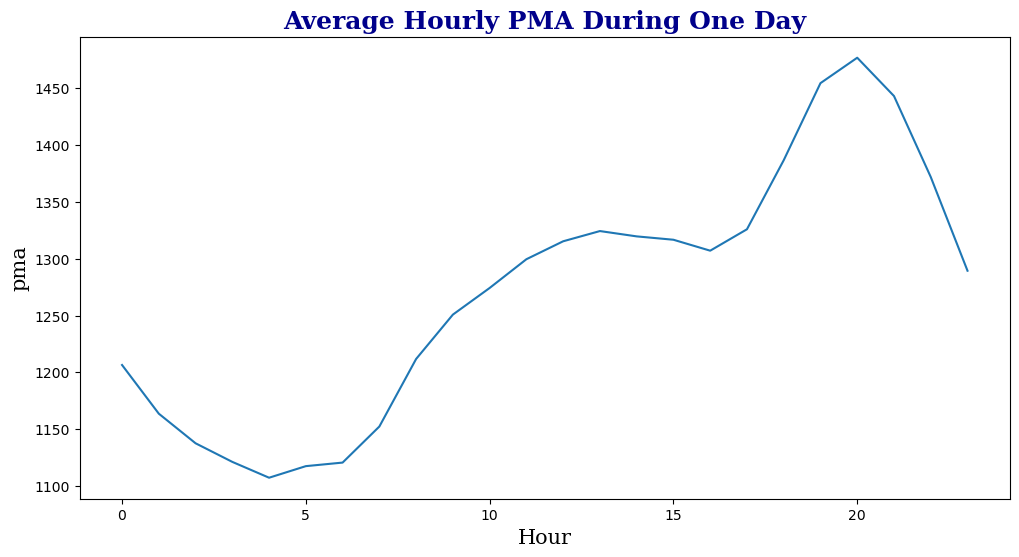

In [42]:
hourly_grouped_pma = df.groupby('hour').pma.agg(hourly_pma='mean')
#hourly_grouped_pma
line_plot(hourly_grouped_pma, 'hour', 'hourly_pma', 'Average Hourly PMA During One Day', 'Hour', 'pma')

However, this one is for both two years, let us do it for each season and try to compare.

In [61]:
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

def map_season(month, day):
    if (month == 12 and day >= 21) or (month == 1) or (month == 2) or (month == 3 and day < 21):
        return seasons[0]  # Winter
    elif (month == 3 and day >= 21) or (month == 4) or (month == 5) or (month == 6 and day < 21):
        return seasons[1]  # Spring
    elif (month == 6 and day >= 21) or (month == 7) or (month == 8) or (month == 9 and day < 21):
        return seasons[2]  # Summer
    else:
        return seasons[3]  # Fall

# Assign seasons to each day, month, and hour
df['season'] = df.apply(lambda row: map_season(row.month, row.day), axis=1)

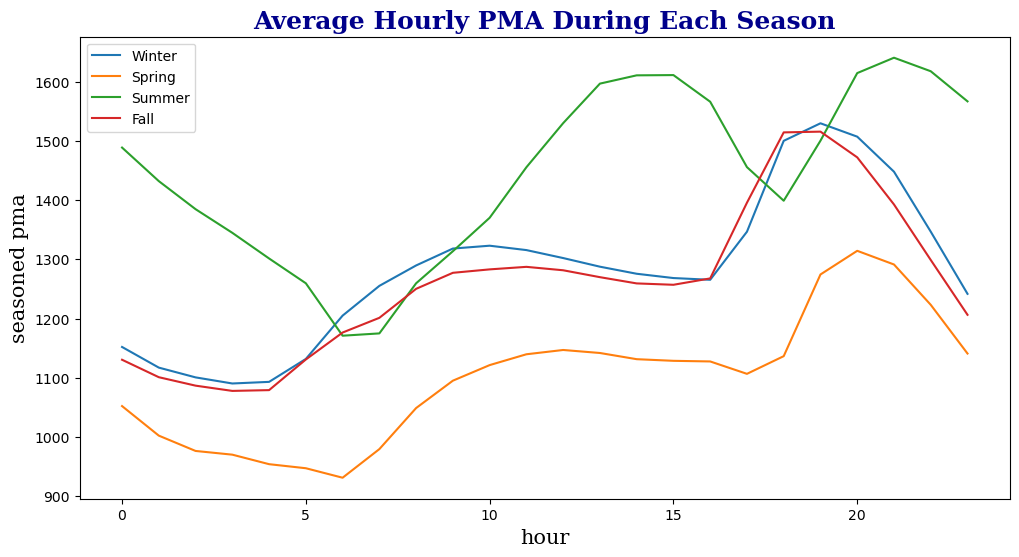

In [64]:
seasoned_hourly_grouped_pma = df.groupby(['season', 'hour']).pma.agg(seasoned_hourly_pma='mean')
fall_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Fall']
winter_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Winter']
spring_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Spring']
summer_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Summer']

plt.figure(figsize=[12, 6])
plt.title('Average Hourly PMA During Each Season', fontdict=title_style)
plt.ylabel('seasoned pma', fontdict=labels_style)
plt.xlabel('hour', fontdict=labels_style)

for season in seasons:
    seasoned_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')==season]
    #line_plot(seasoned_hourly, 'hour', 'seasoned_hourly_pma', f'Average Hourly Demand in {season}', 'Hour', 'pma')
    sns.lineplot(data=seasoned_hourly, x='hour', y='seasoned_hourly_pma', label=season)

plt.show()

#### Key notes

* Power demand reaches its maximum values during summer. Which logical, most people are in holidays thus staying at home most of the time compared to the rest of the year.
* During one day, PMA reaches its climax at around 8pm.
* During Winter, max demand is at its peak before 8pm, and after that time it starts decreasing. This could be due to many reasons. One of them is that people tend to sleep earlier at winter. Meanwhile during summer, it reaches its climax after 8pm and higher values as well 1pm and 4pm. Because, most people are at their homes with their AC (Air Conditioner) on at those times due to high temperatures outside.
* Demand is low in all seasons during night (most logically) and medium during day where everyone are doing their activities and daily tasks.

### Relationships

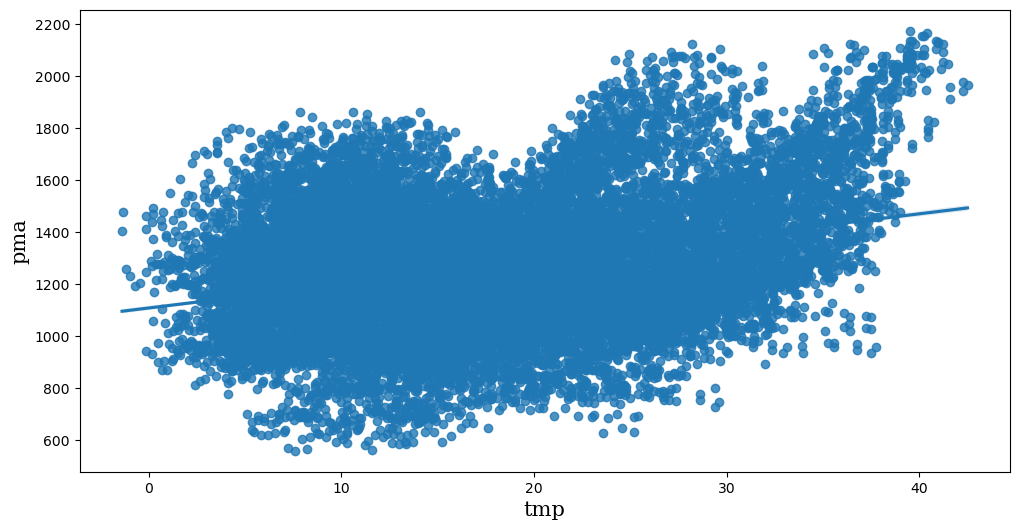

In [19]:
#df
def scatter_plot(data, x, y, title='', xlabel='', ylabel='', rotate_x=0):
    title_style = {'family':'serif','color':'darkblue','size':18, 'weight':'bold'}
    labels_style = {'family':'serif','color':'black','size':15}
    plt.figure(figsize=[12, 6])
    plt.title(title, fontdict=title_style)
    plt.ylabel(ylabel, fontdict=labels_style)
    plt.xlabel(xlabel, fontdict=labels_style)
    plt.xticks(rotation=rotate_x)
    sns.regplot(data=data, x=x, y=y)
    plt.show()
scatter_plot(df, 'tmp', 'pma')

#### Clustering with KMeans

In [89]:
def kmeans(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
    print(f'centroids.shape: {centroids.shape}')
     
    #finding the distance between centroids and all the data points
    distances = cdist(x, centroids ,'euclidean') #Step 2
    print(f'distances.shape: {distances.shape}')
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
    print(f'points.shape: {points.shape}')
    
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for i in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points